# Bayesian VAE 

In [1]:
from pathlib import Path

import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

import matplotlib.pyplot as plt
import numpy as np

import pmldiku
from pmldiku import data, vae, model_utils

%load_ext autoreload
%autoreload 1
%aimport pmldiku.data, pmldiku.vae, pmldiku.model_utils

In [2]:
torch.manual_seed(1)

CUDA = True
BATCH_SIZE = 128
LOGPX_LOSS = "mse"
DEVICE_NAME = "cuda" if CUDA else "cpu"

DEVICE = torch.device(DEVICE_NAME)
kwargs = {'num_workers': 4, 'pin_memory': DEVICE} 

In [3]:
# Val equals test here :)
train_loader = data.load_mnist(train=True).setup_data_loader(batch_size=BATCH_SIZE, **kwargs)
val_loader = data.load_mnist(train=False).setup_data_loader(batch_size=BATCH_SIZE, **kwargs)  

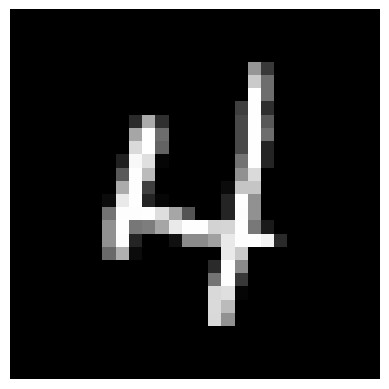

In [4]:
X, y = next(iter(train_loader))
img = X[0].squeeze().numpy()
model_utils.plot_img(img)

# Train model

In [6]:
# Model
bayes_vae = vae.BayesVAE(hidden_dim=2)
model = vae.LitBayesVAE(vae=bayes_vae, logpx_loss=LOGPX_LOSS)

# Callbacks
loss_callback = vae.VAELossCallback()
reconstruct_cb = vae.VAEImageReconstructionCallback()
cb_checkpoint = ModelCheckpoint(
    dirpath=pmldiku.FP_MODELS,
    filename='mnist-BayesVAE-MSE-{epoch:02d}-{val_loss:.2f}'
)
cb_earlystopping = EarlyStopping(monitor="val_loss", mode="min", patience=5)
callbacks = [loss_callback, reconstruct_cb, cb_checkpoint, cb_earlystopping]

# Trainer
trainer = pl.Trainer(max_epochs=-1, devices=1, accelerator=DEVICE_NAME, callbacks=callbacks)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [7]:
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

/scratch/fjr906/miniconda3/envs/pml/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:604: UserWarning: Checkpoint directory /scratch/fjr906/projects/pml/pmldiku-exam-paper/code/models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name | Type     | Params
----------------------------------
0 | vae  | BayesVAE | 985 K 
----------------------------------
985 K     Trainable params
0         Non-trainable params
985 K     Total params
3.943     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

(array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False,
        False, False,  True, False,  True, False,  True, False, False]),
 array([305679.125     , 184788.703125  , 122830.859375  ,  84582.578125  ,
         59702.98828125,  43504.08984375,  32939.19921875,  26283.39648438,
         22095.87304688,  19442.84375   ,  17760.16015625,  16789.39257812,
         16152.91210938,  15667.38085938,  15468.34863281,  15279.5859375 ,
         15097.31347656,  15037.30371094,  14945.93164062,  14901.25585938,
         14880.015625  ,  14845.10058594,  14799.98046875,  14835.01269531,
         14794.8671875 ,  14744.33789062,  14736.6015625 ,  14728.4140625 ,
         14697.66210938,  14660.72363281,  14664.125     ,  14617.65722656,
         14711.45800781,  14629.79882812,  14655.83886719,  14645.63476562,
         14618.72460938]))

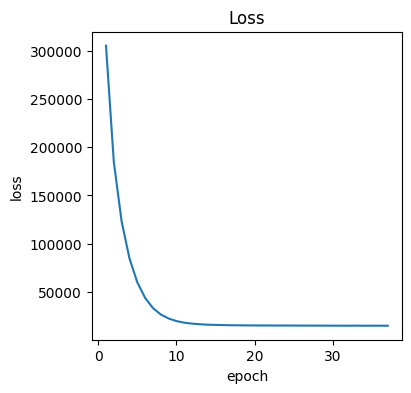

In [8]:
losses = np.array(loss_callback.val_loss)
model_utils.plot_loss(losses)
np.diff(losses) > 0, losses

# Reconstruction of model for each epoch of training

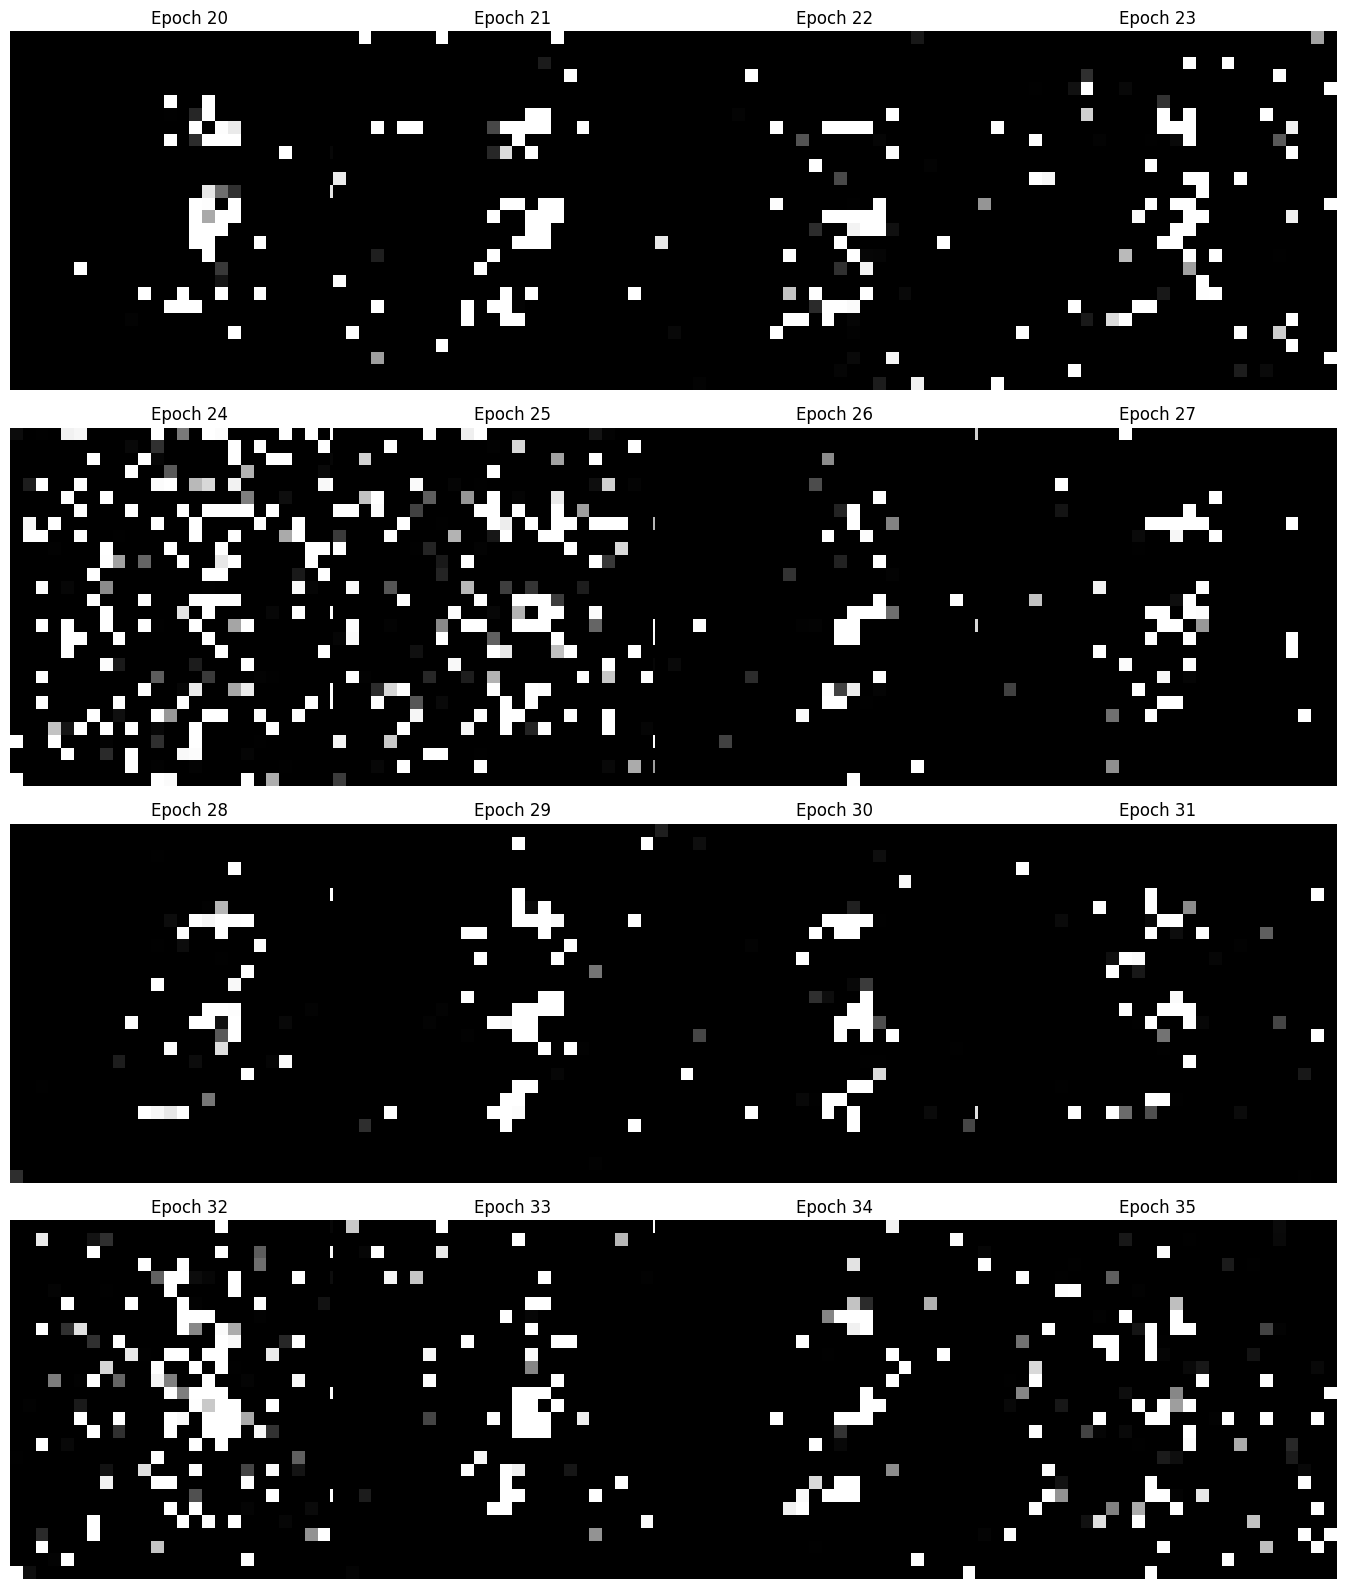

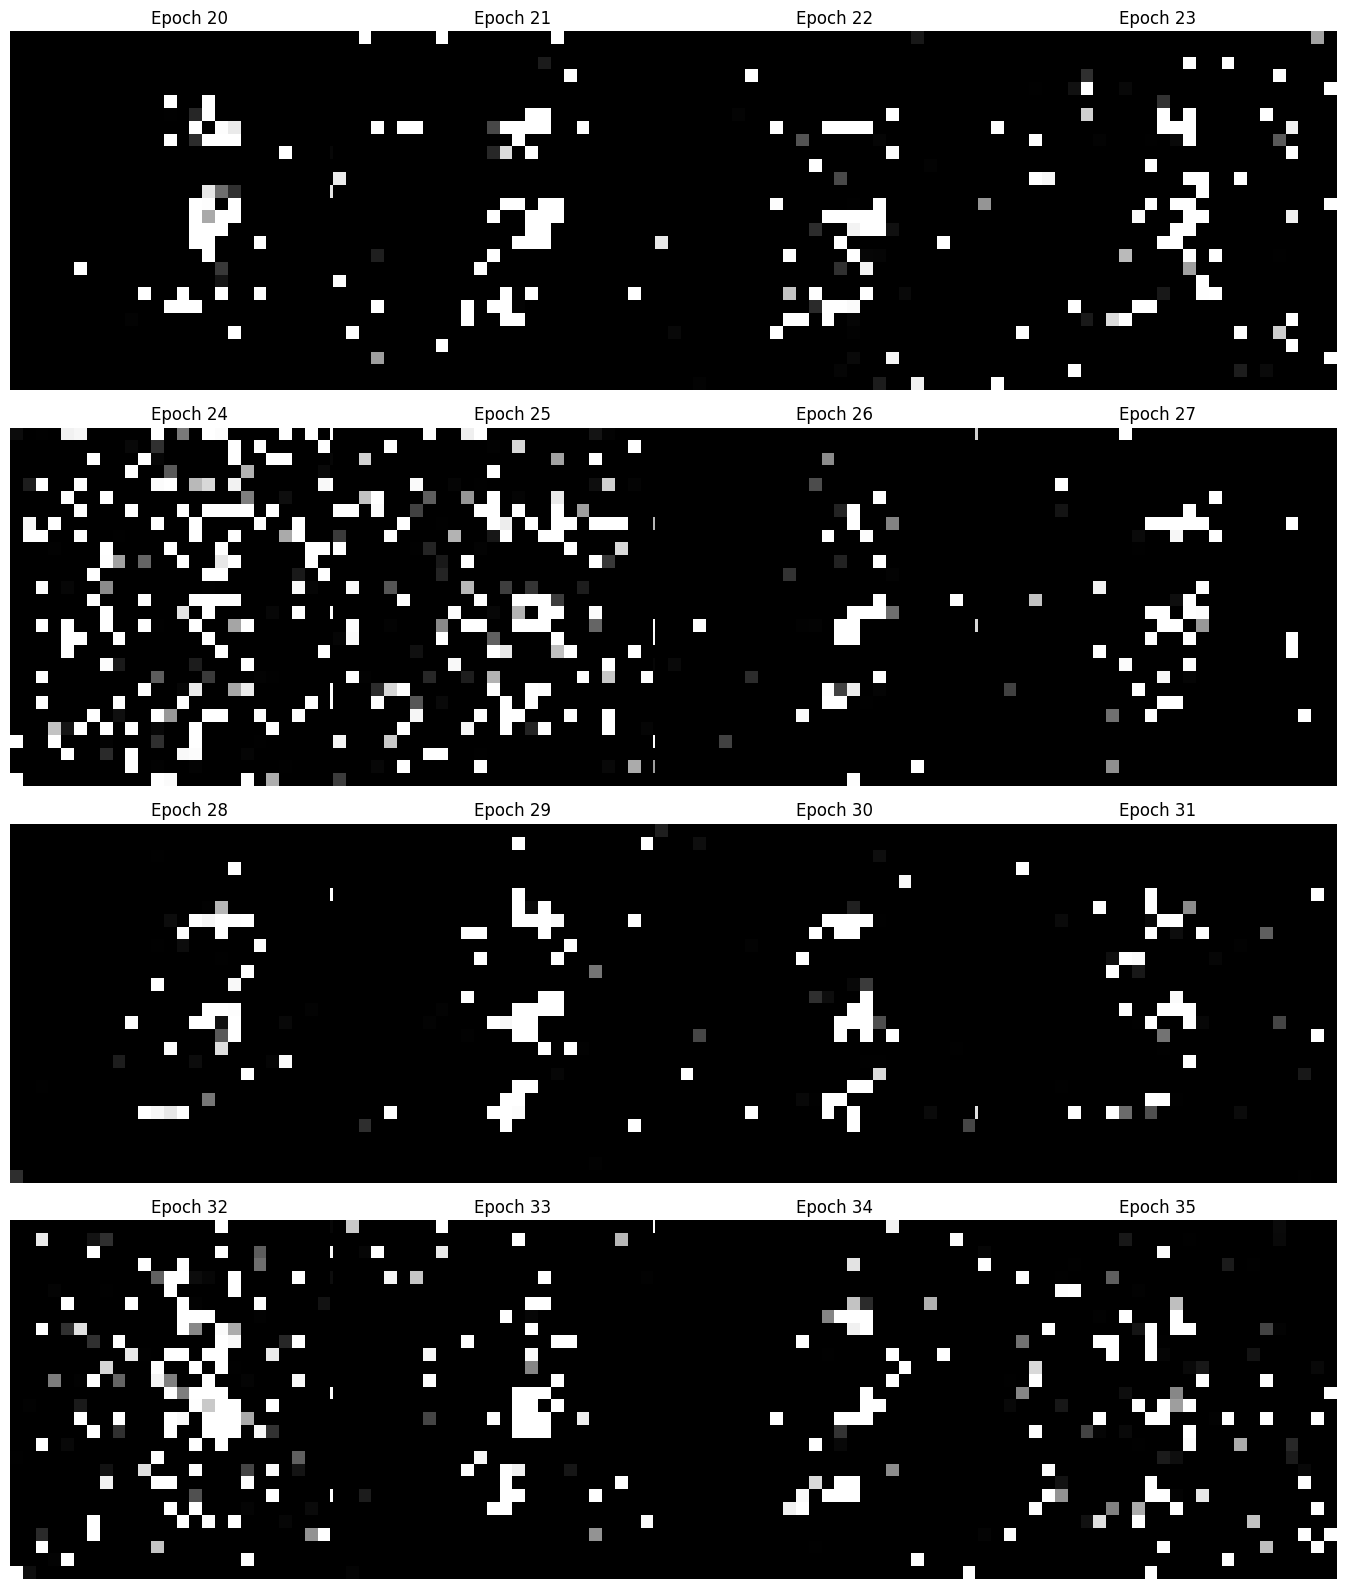

In [10]:
# Take first image of each batch of reconstructed images
images = reconstruct_cb.samples[-16:, 0, :, :].cpu().numpy()
start = cb_earlystopping.stopped_epoch - 16
model_utils.plot_image_reconstruction(images, num_cols=4, slim=20, start=start, **{"title": "Epoch"})

# Expected value in latent space for each number

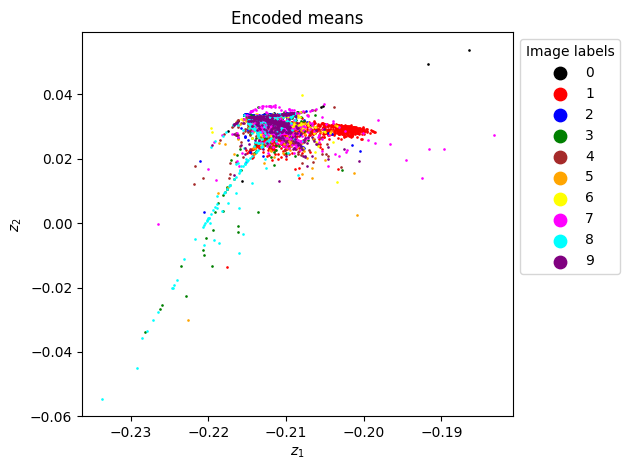

In [11]:
means_plot, labels = vae.encode_means(model.vae, val_loader)
plot_args = dict(title="Encoded means", xlabel=r"$z_1$", ylabel=r"$z_2$")
model_utils.plot_encoded(means_plot, labels, **plot_args)

# Reconstruction of equally spaced gaussian noise

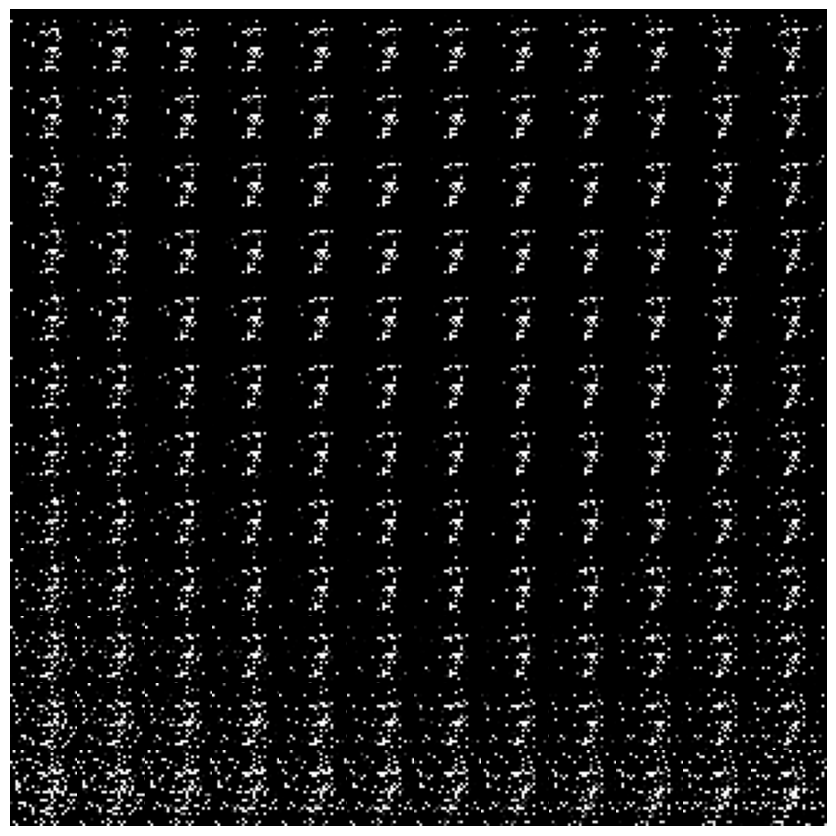

In [12]:
gauss_vals = model_utils.construct_gauss_grid(M=12)
decoded_imgs = model.vae.decode(gauss_vals).detach().numpy()
model_utils.plot_gauss_grid_imgs(decoded_imgs)

# Inspect output

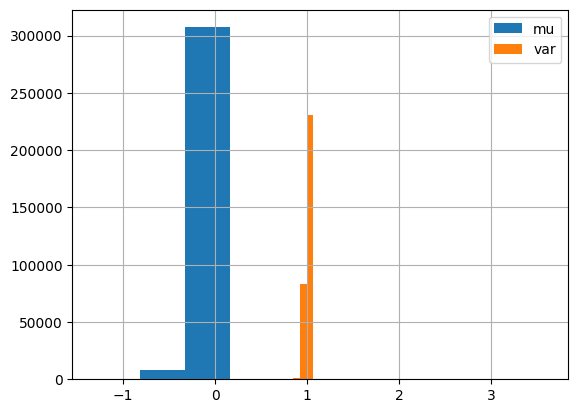

In [13]:
import pandas as pd
pd.Series(model.vae.mu_theta.detach().numpy()).hist(label="mu")
pd.Series(torch.exp(0.5 * model.vae.logvar_theta).detach().numpy()).hist(label="var")
plt.legend()